In [1]:
import os
import sys
import argparse
import numpy as np
import numba as nb
import scipy.stats
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
from tools import merge_matrix, hic_norm, clean_matrix

In [28]:
cell_line, chr = 'K562', 19
chr_file_name = 'chr{}_1000b.npz'.format(chr)
analyse_path = '/data1/lmh_data/MMSR_complete/analyse/'
hr_path = os.path.join(analyse_path, cell_line, 'use_data', 'hr', chr_file_name)
replaced_path = os.path.join(analyse_path, cell_line, 'use_data', 'replaced', chr_file_name)
result_path = os.path.join(analyse_path, cell_line, 'validation', chr_file_name)

hr = np.load(hr_path)['hic']
print(hr.shape)

replaced = np.load(replaced_path)['hic']
print(replaced.shape)

result = np.load(result_path)['out']
print(result.shape)

(147, 5, 400, 400)
(147, 5, 400, 400)
(147, 5, 400, 400)


In [29]:
hr = hic_norm(hr)
replaced = hic_norm(replaced)
result[result>255] = 255

hr = hr.astype(np.uint8)
replaced = replaced.astype(np.uint8)
result = result.astype(np.uint8)

In [30]:
hr = merge_matrix(hr)
hr = np.triu(hr).T + np.triu(hr)

replaced = merge_matrix(replaced)
replaced = np.triu(replaced).T + np.triu(replaced)

result = merge_matrix(result)
result = np.triu(result).T + np.triu(result)

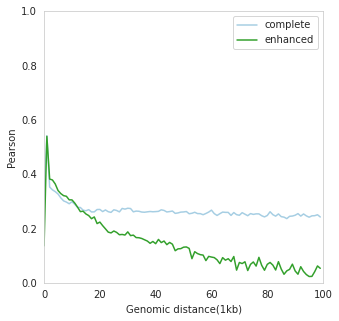

complete_y: 0.26640540955594266
enhanced: 0.14541063136999643


In [31]:
# 1kb PCC
distance_all = [[0, chr]]
dic_norm = {}
length = 100 # 100kb
for i in range(length):
    dic_norm[i]=[[], [], []]
for i in range(len(distance_all)):
    for j in range(-length+1, length, 1):
        dis = distance_all[i][0] - j
        dic_norm[abs(dis)][0]+=hr.diagonal(offset=j).tolist()
        dic_norm[abs(dis)][1]+=replaced.diagonal(offset=j).tolist()
        dic_norm[abs(dis)][2]+=result.diagonal(offset=j).tolist()

complete_y, result_y = [], []
for i in range(length):
    complete_y.append(scipy.stats.pearsonr(dic_norm[i][0], dic_norm[i][1])[0])
    result_y.append(scipy.stats.pearsonr(dic_norm[i][0], dic_norm[i][2])[0])

import seaborn as sns
sns.set_style("whitegrid") 
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), sharey=True)
axes.grid(False)
axes.plot(list(range(100)), complete_y, color=(166/255, 206/255, 227/255), label='complete')
axes.plot(list(range(100)), result_y, color=(51/255, 160/255, 44/255), label='enhanced')

plt.ylim(0, 1)
plt.xlabel('Genomic distance(1kb)')
plt.ylabel('Pearson')
plt.xlim(0, length)
plt.legend()
# plt.savefig('fig/fig4_10kb_PCC.pdf')
plt.show()

print("complete_y: {}".format(np.mean(complete_y)))
print("enhanced: {}".format(np.mean(result_y)))